# Colorization Network

## Imports

In [1]:
import os
import math
import random

import cv2

import PIL

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.color import lab2rgb, rgb2lab
from skimage import io

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset

## Define Dataset

In [2]:
class ImageDataset(Dataset):
    """Colrization image dataset."""

    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        image_paths = os.listdir(root_dir)
        image_paths = [image_path for image_path in image_paths if image_path.endswith('.jpg')]
        random.shuffle(image_paths)
        
        self.image_paths = np.array(image_paths)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.image_paths[idx])
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

        if self.transform:
            image_lab = self.transform(image)
            image_gray = image_lab[0:1,:,:]
            image_ab = self.transform(image)[1:,:,:]
        
        sample = (image_gray, image_lab, image_ab)

        return sample

In [3]:
transform = transforms.Compose([transforms.ToTensor()])

transformed_train_dataset = ImageDataset(root_dir='./TrainSet',
                                         transform=transform)
transformed_test_dataset = ImageDataset(root_dir='./TestSet',
                                         transform=transform)

## Train/Test Split

In [4]:
batch_size = 8

trainloader = torch.utils.data.DataLoader(transformed_train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(transformed_test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

## Plot some images

In [5]:
def imshow(img):
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    npimg = npimg.astype('float64')
    plt.imshow(npimg)
    plt.show()

In [6]:
# get some random training images
dataiter = iter(trainloader)
images_gray, images_color, images_ab = dataiter.next()

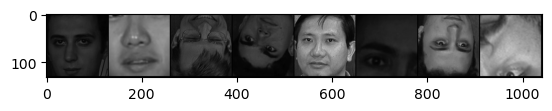

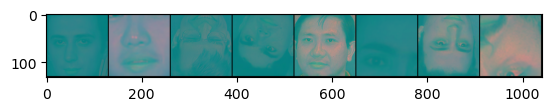

In [7]:
# show some images
imshow(torchvision.utils.make_grid(images_gray))
imshow(torchvision.utils.make_grid(images_color))

## Define network

In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.downsample = nn.Sequential(
            nn.Conv2d(1, 8, 3, 2, 1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 32, 3, 2, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 128, 3, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(128, 32, 2, 2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 8, 2, 2),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 2, 2, 2),
            nn.ReLU()
            #nn.Tanh()
        )

    def forward(self, x):
        midlevel = self.downsample(x)
        output = self.upsample(midlevel)
        return output

net = Net()

### Move to cuda if possible

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
print(device)

cuda:0


## Define optimizer

In [11]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-2, weight_decay=0.0)

## Train

In [12]:
num_mini_batch_print = 50

for epoch in range(3):  # loop over the dataset multiple times
    print(f'----epoch: {epoch + 1}')
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        images_gray, images_color, images_ab = data[0].to(device), data[1].to(device), data[2].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(images_gray)
        loss = criterion(outputs, images_ab)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % num_mini_batch_print == num_mini_batch_print - 1:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / num_mini_batch_print))
            running_loss = 0.0

print('Finished Training')

----epoch: 1
[1,    50] loss: 0.062
[1,   100] loss: 0.001
[1,   150] loss: 0.001
[1,   200] loss: 0.001
[1,   250] loss: 0.001
[1,   300] loss: 0.000
[1,   350] loss: 0.000
[1,   400] loss: 0.000
[1,   450] loss: 0.000
[1,   500] loss: 0.000
[1,   550] loss: 0.000
[1,   600] loss: 0.000
[1,   650] loss: 0.000
[1,   700] loss: 0.000
[1,   750] loss: 0.000
[1,   800] loss: 0.000
----epoch: 2
[2,    50] loss: 0.000
[2,   100] loss: 0.000
[2,   150] loss: 0.000
[2,   200] loss: 0.000
[2,   250] loss: 0.000
[2,   300] loss: 0.000
[2,   350] loss: 0.000
[2,   400] loss: 0.000
[2,   450] loss: 0.000
[2,   500] loss: 0.000
[2,   550] loss: 0.000
[2,   600] loss: 0.000
[2,   650] loss: 0.000
[2,   700] loss: 0.000
[2,   750] loss: 0.000
[2,   800] loss: 0.000
----epoch: 3
[3,    50] loss: 0.000
[3,   100] loss: 0.000
[3,   150] loss: 0.000
[3,   200] loss: 0.000
[3,   250] loss: 0.000
[3,   300] loss: 0.000
[3,   350] loss: 0.000
[3,   400] loss: 0.000
[3,   450] loss: 0.000
[3,   500] loss: 0

## Save Model

In [13]:
PATH = './colorize_net.pth'
torch.save(net.state_dict(), PATH)

## Evaluate Model
### Peak at 4 test examples

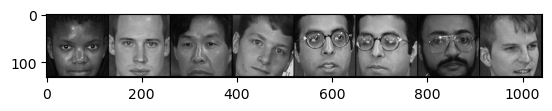

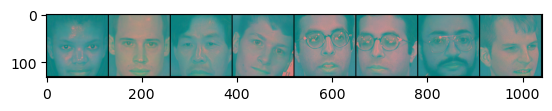

In [14]:
dataiter = iter(testloader)
images_gray, images_color, images_ab = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images_gray))
imshow(torchvision.utils.make_grid(images_color))

### Look at model performance on these examples

In [15]:
outputs = net(images_gray.to(device)).cpu()

### Combine l, a and b channels

In [16]:
outputs = torch.cat((images_gray, outputs), 1)

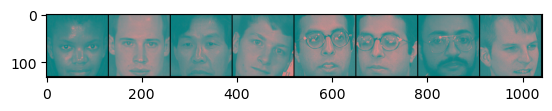

In [17]:
imshow(torchvision.utils.make_grid(outputs))

## Convert Tensor output to RGB

In [18]:
def tensor_to_rgb(tensors):
    images_RGB = []

    for tensor in tensors:
        color_image = tensor.detach().clone().numpy()
        color_image = np.transpose(color_image, (1,2,0))
        color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
        color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128   
        color_image = lab2rgb(color_image.astype(np.float64))
        color_image = np.transpose(color_image, (2,0,1))
        images_RGB.append(color_image)

    return torch.tensor(np.array(images_RGB))

Input:


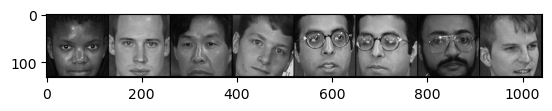

Ground truth:


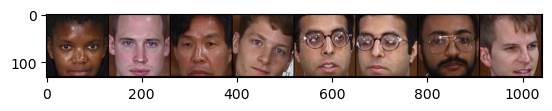

Colorize Net outputs:


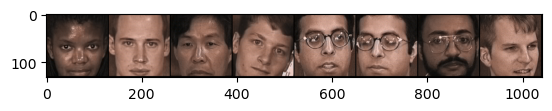

In [19]:
print('Input:')
imshow(torchvision.utils.make_grid(images_gray))
print('Ground truth:')
imshow(torchvision.utils.make_grid(tensor_to_rgb(images_color)))
print('Colorize Net outputs:')
imshow(torchvision.utils.make_grid(tensor_to_rgb(outputs)))